In [ ]:
#!git clone https://github.com/eriklindernoren/PyTorch-YOLOv3.git
#%cd PyTorch-YOLOv3
#!sudo pip3 install -r requirements.txt
#!bash weights/download_weights.sh
#%cd config/
#!bash create_custom_model.sh 6

#%cd .. 



In [2]:
import os
import sys
import tarfile
import collections
import torch
import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity
from torchvision import datasets
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
import argparse
from models import *
from torch.utils.data import DataLoader
from utils.logger import *
from utils.utils import *
from utils.datasets import *
from utils.parse_config import *
from terminaltables import AsciiTable
import datetime
from test import evaluate
from torch.autograd import Variable
from matplotlib.ticker import NullLocator
%matplotlib notebook


In [3]:
root = 'dataset_project'

dataset_train = tv.datasets.VOCDetection(root, year='2012', image_set='train',transform = None, 
                                   target_transform = None, download = False)

dataset_val = tv.datasets.VOCDetection(root, year='2012', image_set='trainval',transform = None, 
                                   target_transform = None, download = False)

dataset_test = tv.datasets.VOCDetection(root, year='2012', image_set='val',transform = None, 
                                   target_transform = None, download = False)

dataset_origin = tv.datasets.VOCDetection(root, year='2012', image_set='val',transform = None, 
                                   target_transform = None, download = False)



In [4]:
def myimshow(image, ax=plt):
#     image = image.to('cpu').detach().numpy()
    image = np.moveaxis(image.numpy(), [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h



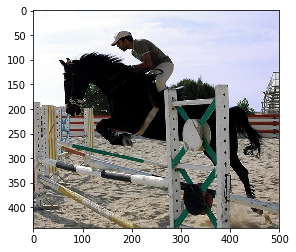

In [5]:
x, d = dataset_train[0]

plt.imshow(x)

y, f = dataset_val[1]

z, e = dataset_test[8]


In [11]:
class YOLODataset(Dataset):
    def __init__(self, dataset, img_size = (224, 224)):
        super(YOLODataset, self).__init__()
        self.img_size = img_size
#         self.augment = augment
        self.dataset = dataset
#     self.batch_count = 0
    
    def __getitem__(self, index):
        img, target = self.dataset[index]
        img = img.convert('RGB')
        transform = tv.transforms.Compose([
                tv.transforms.ToTensor(),
                tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])
        img = transform(img)
        h_factor = img.numpy().shape[1]
        w_factor = img.numpy().shape[2]
#         img, pad = pad_to_square(img, 0)
#         _, padded_h, padded_w = img.shape

        targets = None
        object_to_idx = {'aeroplane': 0,'bicycle': 1,'bird': 2,'boat': 3,
                  'bottle': 4,'bus': 5,'car': 6,'cat': 7,
                  'chair': 8,'cow': 9,'diningtable': 10,'dog': 11,
                  'horse': 12,'motorbike': 13,'person': 14,'pottedplant': 15,
                  'sheep': 16,'sofa': 17,'train': 18,'tvmonitor': 19}
    
    
        h = target['annotation']['size']['height']
        h = float(h)
        w = target['annotation']['size']['width']
        w = float(w)

        if isinstance(target['annotation']['object'], list):
            boxes = [[object_to_idx[x['name']]] + [x['bndbox']['xmin'],x['bndbox']['ymin'],x['bndbox']['xmax'],x['bndbox']['ymax']] for x in target['annotation']['object']]
        elif isinstance(target['annotation']['object'], dict):
            x = target['annotation']['object']['bndbox']
            boxes = [object_to_idx[target['annotation']['object']['name']]] + [x['xmin'],x['ymin'],x['xmax'],x['ymax']]
        else:
            print('I do not know what happened')
        boxes = np.array(boxes).astype(np.float)
        boxes = boxes.reshape(-1, 5)
#         boxes[:, 1] = boxes[:, 1] / w
#         boxes[:, 2] = boxes[:, 2] / h
#         boxes[:, 3] = boxes[:, 3] / w
#         boxes[:, 4] = boxes[:, 4] / h
        x1 = boxes[:, 1] / w
        y1 = boxes[:, 2] / h
        x2 = boxes[:, 3] / w
        y2 = boxes[:, 4] / h
        # Extract coordinates for unpadded + unscaled image
#         x1 = w_factor * (boxes[:, 1])# - boxes[:, 3] / 2)
#         y1 = h_factor * (boxes[:, 2])# - boxes[:, 4] / 2)
#         x2 = w_factor * (boxes[:, 3])# + boxes[:, 3] / 2)
#         y2 = h_factor * (boxes[:, 4])# + boxes[:, 4] / 2)
        # Adjust for added padding
#         x1 += pad[0]
#         y1 += pad[2]
#         x2 += pad[1]
#         y2 += pad[3]
        # Returns (x, y, w, h)
        box_w = (x2 - x1) 
        box_h = (y2 - y1) 
        boxes[:, 1] = ((x1 + x2) / 2) #/ padded_w
        boxes[:, 2] = ((y1 + y2) / 2) #/ padded_h
        boxes[:, 3] = box_w #/ padded_w
        boxes[:, 4] = box_h #/ padded_h
#         boxes[:, 3] *= w_factor / padded_w
#         boxes[:, 4] *= h_factor / padded_h
        
        targets = torch.zeros((len(boxes), 6))
        targets[:, 1:] = torch.Tensor(boxes)
        targets[targets != targets] = 0
#     # Apply augmentations
#     if self.augment:
#         if np.random.random() < 0.5:
#             img, targets = horisontal_flip(img, targets)
    
        return img, targets
  
    def collate_fn(self, batch):
        imgs, targets = list(zip(*batch))
      # Remove empty placeholder targets
        targets = [boxes for boxes in targets if boxes is not None]
      # Add sample index to targets
        for i, boxes in enumerate(targets):
            boxes[:, 0] = i
        targets = torch.cat(targets, 0)
#       # Selects new image size every tenth batch
#       if self.multiscale and self.batch_count % 10 == 0:
#           self.img_size = random.choice(range(self.min_size, self.max_size + 1, 32))
      # Resize images to input shape
        imgs = torch.stack([resize(img, self.img_size) for img in imgs])
#         self.batch_count += 1
        return imgs, targets
    
    def __len__(self):
        return len(self.dataset)
    

5717
11540
5823


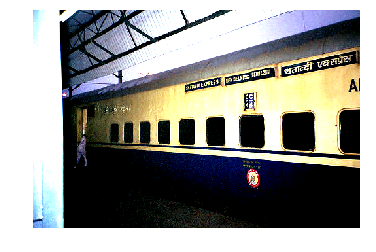

In [12]:
trainset = YOLODataset(dataset_train)
valset = YOLODataset(dataset_val)
testset = YOLODataset(dataset_test)

print(len(trainset))
print(len(valset))
print(len(testset))

x, y = testset[1]

myimshow(x)


torch.Size([3, 272, 480])
tensor([[ 0.0000, 11.0000,  0.5323,  0.3658,  0.4854,  0.7169],
        [ 0.0000, 11.0000,  0.5031,  0.5551,  0.3187,  0.6250],
        [ 0.0000, 11.0000,  0.8760,  0.2077,  0.2479,  0.4081]])


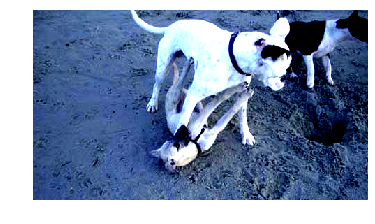

In [13]:
x, d = trainset[2]
y, f = valset[1]
z, e = testset[8]

myimshow(x)

print(x.shape)
print(d)

In [14]:
object_to_idx = {'aeroplane': 0,'bicycle': 1,'bird': 2,'boat': 3,
              'bottle': 4,'bus': 5,'car': 6,'cat': 7,
              'chair': 8,'cow': 9,'diningtable': 10,'dog': 11,
              'horse': 12,'motorbike': 13,'person': 14,'pottedplant': 15,
              'sheep': 16,'sofa': 17,'train': 18,'tvmonitor': 19}


class_names = list(object_to_idx.keys())
print(class_names)



['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [15]:
Argument_Dict = {}
Argument_Dict['epochs'] = 150
Argument_Dict['batch_size'] = 8
Argument_Dict['model_def'] = 'config/yolov3-custom.cfg'
Argument_Dict['pretrain_weights'] = 'For new start'
#Argument_Dict['pretrain_weights'] = 'checkpoints/yolov3_cp_126.pth' #train start
# Argument_Dict['pretrain_weights'] = 'checkpoints/yolov3_cp_21.pth' #test
#59 mAP is 0.55
Argument_Dict['yolov3_weights'] = 'weights/yolov3.weights'
Argument_Dict['n_cpu'] = 2
Argument_Dict['gradient_accumulations'] = 2
Argument_Dict['evaluation_interval'] = 1
Argument_Dict['checkpoint_interval'] = 1
Argument_Dict['img_size'] = 224
Argument_Dict['conf_thres'] = 0.8 #object confidence threshold
Argument_Dict['nms_thres'] = 0.4 #iou thresshold for non-maximum suppression"

print(Argument_Dict)



{'epochs': 150, 'batch_size': 8, 'model_def': 'config/yolov3-custom.cfg', 'pretrain_weights': 'For new start', 'yolov3_weights': 'weights/yolov3.weights', 'n_cpu': 2, 'gradient_accumulations': 2, 'evaluation_interval': 1, 'checkpoint_interval': 1, 'img_size': 224, 'conf_thres': 0.8, 'nms_thres': 0.4}


In [12]:
logger = Logger("logs")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)



cuda


In [13]:
model = Darknet(Argument_Dict['model_def']).to(device)
model.apply(weights_init_normal)


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [14]:

# If specified we start from checkpoint
if Argument_Dict['pretrain_weights']:
    if Argument_Dict['pretrain_weights'].endswith(".pth"):
        model.load_state_dict(torch.load(Argument_Dict['pretrain_weights']))
        print('load state dict')
    else:
        model.load_darknet_weights(Argument_Dict['yolov3_weights'])
        print('load darknet weights')
        
        

load darknet weights


In [15]:
dataloader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size= Argument_Dict['batch_size'],
    num_workers= Argument_Dict['n_cpu'],
    shuffle = True,
    pin_memory= True,
    drop_last = True,
    collate_fn= trainset.collate_fn,
)



In [16]:

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)


In [17]:
metrics = [
    "grid_size",
    "loss",
    "x",
    "y",
    "w",
    "h",
    "conf",
    "cls",
    "cls_acc",
    "recall50",
    "recall75",
    "precision",
    "conf_obj",
    "conf_noobj",
]
    
    

In [18]:
#important !!!
#create files to save parameters only run once
save_loss_path = 'loss_list.npy'
save_map_path = 'map_list.npy'
save_precision_path = 'precision_list.npy'
if not os.path.exists(save_loss_path):
    loss_list = []
    np.save(save_loss_path, loss_list)
    print(1)
if not os.path.exists(save_map_path):
    map_list = []
    np.save(save_map_path, map_list)
    print(2)
if not os.path.exists(save_precision_path):    
    precision_list = []
    np.save(save_precision_path, precision_list)
    print(3)
    

In [19]:
for epoch in range(116,Argument_Dict['epochs']):
    model.train()
    start_time = time.time()
    for batch_i, (imgs, targets) in enumerate(dataloader):
        batches_done = len(dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
#         print(imgs.cpu().numpy().shape)
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()

        if batches_done % Argument_Dict['gradient_accumulations']:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()

        # ----------------
        #   Log progress
        # ----------------

#         log_str = "\n---- [Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, Argument_Dict['epochs'], batch_i, len(dataloader))

#         metric_table = [["Metrics", *[f"YOLO Layer {i}" for i in range(len(model.yolo_layers))]]]

#         # Log metrics at each YOLO layer
#         for i, metric in enumerate(metrics):
#             formats = {m: "%.6f" for m in metrics}
#             formats["grid_size"] = "%2d"
#             formats["cls_acc"] = "%.2f%%"
#             row_metrics = [formats[metric] % yolo.metrics.get(metric, 0) for yolo in model.yolo_layers]
#             metric_table += [[metric, *row_metrics]]

#             # Tensorboard logging
#             tensorboard_log = []
#             for j, yolo in enumerate(model.yolo_layers):
#                 for name, metric in yolo.metrics.items():
#                     if name != "grid_size":
#                         tensorboard_log += [(f"{name}_{j+1}", metric)]
#             tensorboard_log += [("loss", loss.item())]
#             logger.list_of_scalars_summary(tensorboard_log, batches_done)

#         log_str += AsciiTable(metric_table).table
#         log_str += f"\nTotal loss {loss.item()}"

#         # Determine approximate time left for epoch
# #         epoch_batches_left = len(dataloader) - (batch_i + 1)
# #         time_left = datetime.timedelta(seconds=epoch_batches_left * (time.time() - start_time) / (batch_i + 1))
# #         log_str += f"\n---- ETA {time_left}"

#         print(log_str)

#         model.seen += imgs.size(0)

    if epoch % Argument_Dict['evaluation_interval'] == 0:
        log_str = "\n---- [Epoch %d/%d] ----\n" % (epoch, Argument_Dict['epochs'])
        log_str += f"\nTotal loss {loss.item()}"
        print(log_str)
        
        print("\n---- Evaluating Model ----")
        # Evaluate the model on the validation set
        precision, recall, AP, f1, ap_class = evaluate(
            model,
            dataset=valset, 
            iou_thres=0.5,
            conf_thres=0.5,
            nms_thres=0.5,
            img_size=Argument_Dict['img_size'],
            batch_size=Argument_Dict['batch_size'],
        )
        evaluation_metrics = [
            ("val_precision", precision.mean()),
            ("val_recall", recall.mean()),
            ("val_mAP", AP.mean()),
            ("val_f1", f1.mean()),
        ]
        
        logger.list_of_scalars_summary(evaluation_metrics, epoch)

        # Print class APs and mAP
        ap_table = [["Index", "Class name", "AP"]]
        for i, c in enumerate(ap_class):
            ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
        print(AsciiTable(ap_table).table)
        print(f"---- mAP {AP.mean()}")
        
        
        old_loss = np.load(save_loss_path)
        old_loss = old_loss.tolist()
        old_loss.append(loss.item())
#         np.save(save_loss_path)
        np.save(save_loss_path, old_loss)
        
        old_map = np.load(save_map_path)
        old_map = old_map.tolist()
        old_map.append(AP.mean())
#         np.save(save_map_path)
        np.save(save_map_path, old_map)
        
        old_precision = np.load(save_precision_path)
        old_precision = old_precision.tolist()
        old_precision.append(precision.mean())
#         np.save(save_precision_path)
        np.save(save_precision_path, old_precision)

    if epoch % Argument_Dict['checkpoint_interval'] == 0:
        torch.save(model.state_dict(), f"checkpoints/yolov3_cp_%d.pth" % epoch)
#         Argument_Dict['pretrain_weights'] = 'checkpoints/yolov3_ckpt_%d.pth' % epoch
        
        

Detecting objects:   0%|          | 0/1443 [00:00<?, ?it/s]


---- [Epoch 116/150] ----

Total loss 78.78276062011719

---- Evaluating Model ----


Detecting objects:   3%|▎         | 38/1443 [00:14<09:05,  2.58it/s]

KeyboardInterrupt: 

In [ ]:
print(map_list)

In [70]:
x = np.load('weights.npy')

print(x[1])

0.03782371181936016


In [52]:
##   Test

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
os.makedirs("output", exist_ok=True)

model = Darknet(Argument_Dict['model_def']).to(device)
model.load_state_dict(torch.load(Argument_Dict['pretrain_weights']))
model.eval()
# torch.save(model.state_dict(), f"weights/yolov3_custom_weights.pth")



cuda


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [53]:

dataloader_test = torch.utils.data.DataLoader(
    dataset = testset,
    batch_size= 1,
    num_workers= 1,
#     pin_memory= True,
    drop_last = True,
    collate_fn= testset.collate_fn,
    shuffle = False
)


loader_length = len(dataloader_test)


mini_batch = []
mini_label = []
for batch_i, (local_batch, local_label) in enumerate(dataloader_test):
    mini_batch.append(local_batch)
    mini_label.append(local_label)
    
    
print(len(mini_batch))

KeyboardInterrupt: 

In [14]:
print(len(mini_batch))

5353


In [15]:
print(mini_batch[0].shape)

torch.Size([1, 3, 224, 224])


In [86]:
Argument_Dict['plot'] = 36
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# input_imgs, y = valset[1]
input_imgs = mini_batch[Argument_Dict['plot']]
input_imgs = Variable(input_imgs.type(Tensor))

with torch.no_grad():
    detections = model(input_imgs)
    detections = non_max_suppression(detections, Argument_Dict['conf_thres'], Argument_Dict['nms_thres'])

cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)] 
detections_ori = detections[0]


	+ Label: aeroplane, Conf: 1.00000
0.0
56.0
tensor(133.5823)
tensor(305.7525)
tensor(126.5804)
tensor(42.2495)
	+ Label: aeroplane, Conf: 0.99985
0.0
56.0
tensor(212.5005)
tensor(113.7293)
tensor(164.1418)
tensor(61.5766)


<Figure size 432x288 with 0 Axes>

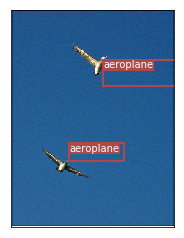

In [87]:
if detections_ori is not None:
    unique_labels = detections[0][:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)

    img, lll = dataset_origin[Argument_Dict['plot']]
    test_img_size = [np.size(img)[0], np.size(img)[1]]
    im = np.array(img)
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(im)
    original_shape = test_img_size
    current_dim = 224
    orig_w, orig_h = original_shape

    new_detections = rescale_boxes(detections_ori, current_dim, test_img_size)

    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections_ori:
        if cls_conf > Argument_Dict['nms_thres']:
            print("\t+ Label: %s, Conf: %.5f" % (class_names[int(cls_pred)], cls_conf.item()))
            x1 = x1 * orig_w / current_dim
            y1 = y1 * orig_h / current_dim
            x2 = x2 * orig_w / current_dim
            y2 = y2 * orig_h / current_dim
            box_w = (x2 - x1)#/ current_dim * max(original_shape) #*  orig_w / current_dim
            box_h = (y2 - y1)#/ current_dim * max(original_shape) #* orig_w / current_dim
#             pad_y = max(orig_h - orig_w, 0) * (current_dim / max(original_shape))
#             pad_x = max(orig_w - orig_h, 0) * (current_dim / max(original_shape))

#             print(pad_x)
#             print(pad_y)
#             x1 = x1 + pad_x - pad_y
#             y1 = y1 + pad_y - 2*pad_x
            print(x1)
            print(y1)
            print(box_w)
            print(box_h)

            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]

            # Create a Rectangle patch
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")


            # Add the bbox to the plot
            ax.add_patch(bbox)

            # Add label
            plt.text(
                x1,
                y1,
                s=class_names[int(cls_pred)],
                color="white",
                verticalalignment="top",
                bbox={"color": color, "pad": 0},
            )
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())  
    # plt.gca().invert_yaxis()
    plt.show()  



In [24]:
object_to_idx


{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

In [37]:
checkpoint = torch.load(Argument_Dict['pretrain_weights'])

for p in checkpoint:
    print(p)

# model.load_state_dict(torch.load(Argument_Dict['pretrain_weights']))



module_list.0.conv_0.weight
module_list.0.batch_norm_0.weight
module_list.0.batch_norm_0.bias
module_list.0.batch_norm_0.running_mean
module_list.0.batch_norm_0.running_var
module_list.0.batch_norm_0.num_batches_tracked
module_list.1.conv_1.weight
module_list.1.batch_norm_1.weight
module_list.1.batch_norm_1.bias
module_list.1.batch_norm_1.running_mean
module_list.1.batch_norm_1.running_var
module_list.1.batch_norm_1.num_batches_tracked
module_list.2.conv_2.weight
module_list.2.batch_norm_2.weight
module_list.2.batch_norm_2.bias
module_list.2.batch_norm_2.running_mean
module_list.2.batch_norm_2.running_var
module_list.2.batch_norm_2.num_batches_tracked
module_list.3.conv_3.weight
module_list.3.batch_norm_3.weight
module_list.3.batch_norm_3.bias
module_list.3.batch_norm_3.running_mean
module_list.3.batch_norm_3.running_var
module_list.3.batch_norm_3.num_batches_tracked
module_list.5.conv_5.weight
module_list.5.batch_norm_5.weight
module_list.5.batch_norm_5.bias
module_list.5.batch_norm_5

In [18]:

# img, lll = dataset_origin[Argument_Dict['plot']]

# test_img_size = [np.size(img)[0], np.size(img)[1]]

# im = np.array(img)
# plt.figure()
# fig, ax = plt.subplots(1)
# ax.imshow(im)


# pad_x = max(orig_h - orig_w, 0) * (current_dim / max(original_shape))
# pad_y = max(orig_w - orig_h, 0) * (current_dim / max(original_shape))
# print(pad_x)
# print(pad_y)
# unpad_h = current_dim - pad_y
# unpad_w = current_dim - pad_x
# print(unpad_h)
# print(unpad_w)
# print(pad_x // 2)
# detectionss = detections_ori
# print(detections_ori)

# detectionssx1 = ((detectionss[:, 0] + pad_x // 2) / unpad_w) * orig_w
# detectionssy1 = ((detectionss[:, 1] + pad_y // 2) / unpad_h) * orig_h
# detectionssx2 = ((detectionss[:, 2] - pad_x // 2) / unpad_w) * orig_w
# detectionssy2 = ((detectionss[:, 3] - pad_y // 2) / unpad_h) * orig_h
# print(detectionssx1)
# print(detectionssy1)
# print(detectionssx2)
# print(detectionssy2)

